# Data Preprocessing for HS300 Stocks

This notebook demonstrates the process of data cleaning and preparation for analyzing the realized volatility of the constituent stocks of the HS300 index. Each step includes acquiring, cleaning, and validating the data to ensure accuracy and reliability for further analysis.

## Data Loading

First, we load the HS300 stocks data from a CSV file to inspect the structure and content.

In [1]:
import pandas as pd
import numpy as np

hs300_stocks = pd.read_csv('hs300_stocks.csv', index_col=0)

## Data Cleaning

In this section, we perform essential data cleaning tasks to prepare the dataset for analysis. The steps include:

1. **Extracting Data Information**:
   - **Start Dates**: Identify the start dates for each stock.
   - **NaN Values**: Calculate the total number of NaN values for each stock.
   - **Consecutive NaN Values**: Determine the total number of consecutive NaN values for each stock.

2. **Filtering Stocks**:
   - Remove stocks with an excessive number of missing values to ensure data quality.

3. **Filling Missing Values**:
   - For the remaining stocks, fill missing values using the median of non-NaN values from all stocks on the same date. This method ensures that the imputed values are representative and consistent with the overall dataset.

In [66]:
def get_info_about_data():
    rv_table = pd.read_csv('realized_volatility/rv_table.csv', index_col=0)
    
    start_date = ['2007-01-01', '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01']
    
    for date in start_date:
        count_start_date = hs300_stocks[hs300_stocks['start_date'] <= date].shape[0]
        codes = hs300_stocks[hs300_stocks['start_date'] <= date]['code']
        date_valid = rv_table.loc[rv_table.index >= date, codes]
        count_na_valid = 0
        count_consecutive_nan_valid = 0
        for col in date_valid.columns:
            count_na = 0
            consecutive_nan = 0
            consecutive_valid = True
            nan_valid = True
            for date_index in date_valid.index:
                if np.isnan(date_valid.loc[date_index, col]):
                    count_na += 1
                    consecutive_nan += 1
                    if consecutive_nan >= 22:
                        consecutive_valid = False
                    if count_na >= 100:
                        nan_valid = False
                else:
                    consecutive_nan = 0
            if nan_valid:
                count_na_valid += 1
            if consecutive_valid:
                count_consecutive_nan_valid += 1
        print(f'There are {count_start_date} stocks have start date in hs300 before {date}.\nFor those stocks, there are {count_na_valid} stocks have less than 100 na values.\nAmong those stocks, there are {count_consecutive_nan_valid} stocks have no consecutive 22 na values.\n')
        
# get_info_about_data()

# filter out those stocks
# 1. start date before specific start date
# 2. have more the nan_threshold nans
def filter_col_date(nan_threshold, date):
    rv_table = pd.read_csv('realized_volatility/rv_table.csv', index_col=0)
    date_valid_col = hs300_stocks[hs300_stocks['start_date'] <= date]['code'] # filter column (stock)
    rv_table_valid = rv_table.loc[rv_table.index > date, date_valid_col] # filter date

    na_valid_col = rv_table_valid.columns[rv_table_valid.isna().sum() < nan_threshold]
    rv_table_valid = rv_table_valid[na_valid_col]
    
    return rv_table_valid

# use the median of non-nan values of all stocks at the same date to fill the nan values
def filter_impute_nan(rv_table):
    for date in rv_table.index:
        non_nan_list = rv_table.loc[date, :].dropna().values
        fill_number = np.median(non_nan_list)
        for col in rv_table.columns:
            if np.isnan(rv_table.loc[date, col]) or rv_table.loc[date, col] == 0:
                rv_table.loc[date, col] = fill_number
    return rv_table

def pre_processing():
    rv_table_valid = filter_col_date(100, '2014-01-01')
    rv_table_valid = filter_impute_nan(rv_table_valid)
    log_rv_table_valid = np.log(rv_table_valid)
    log_rv_table_valid.to_csv('realized_volatility/log_rv_table.csv')

# pre_processing()

## Time Plot of Randomly Chosen Stocks

In this section, we visualize the time series data for some randomly chosen stocks from the dataset. The visualization includes:

1. **Time Plots**
2. **Autocorrelation Function (ACF) Plots**

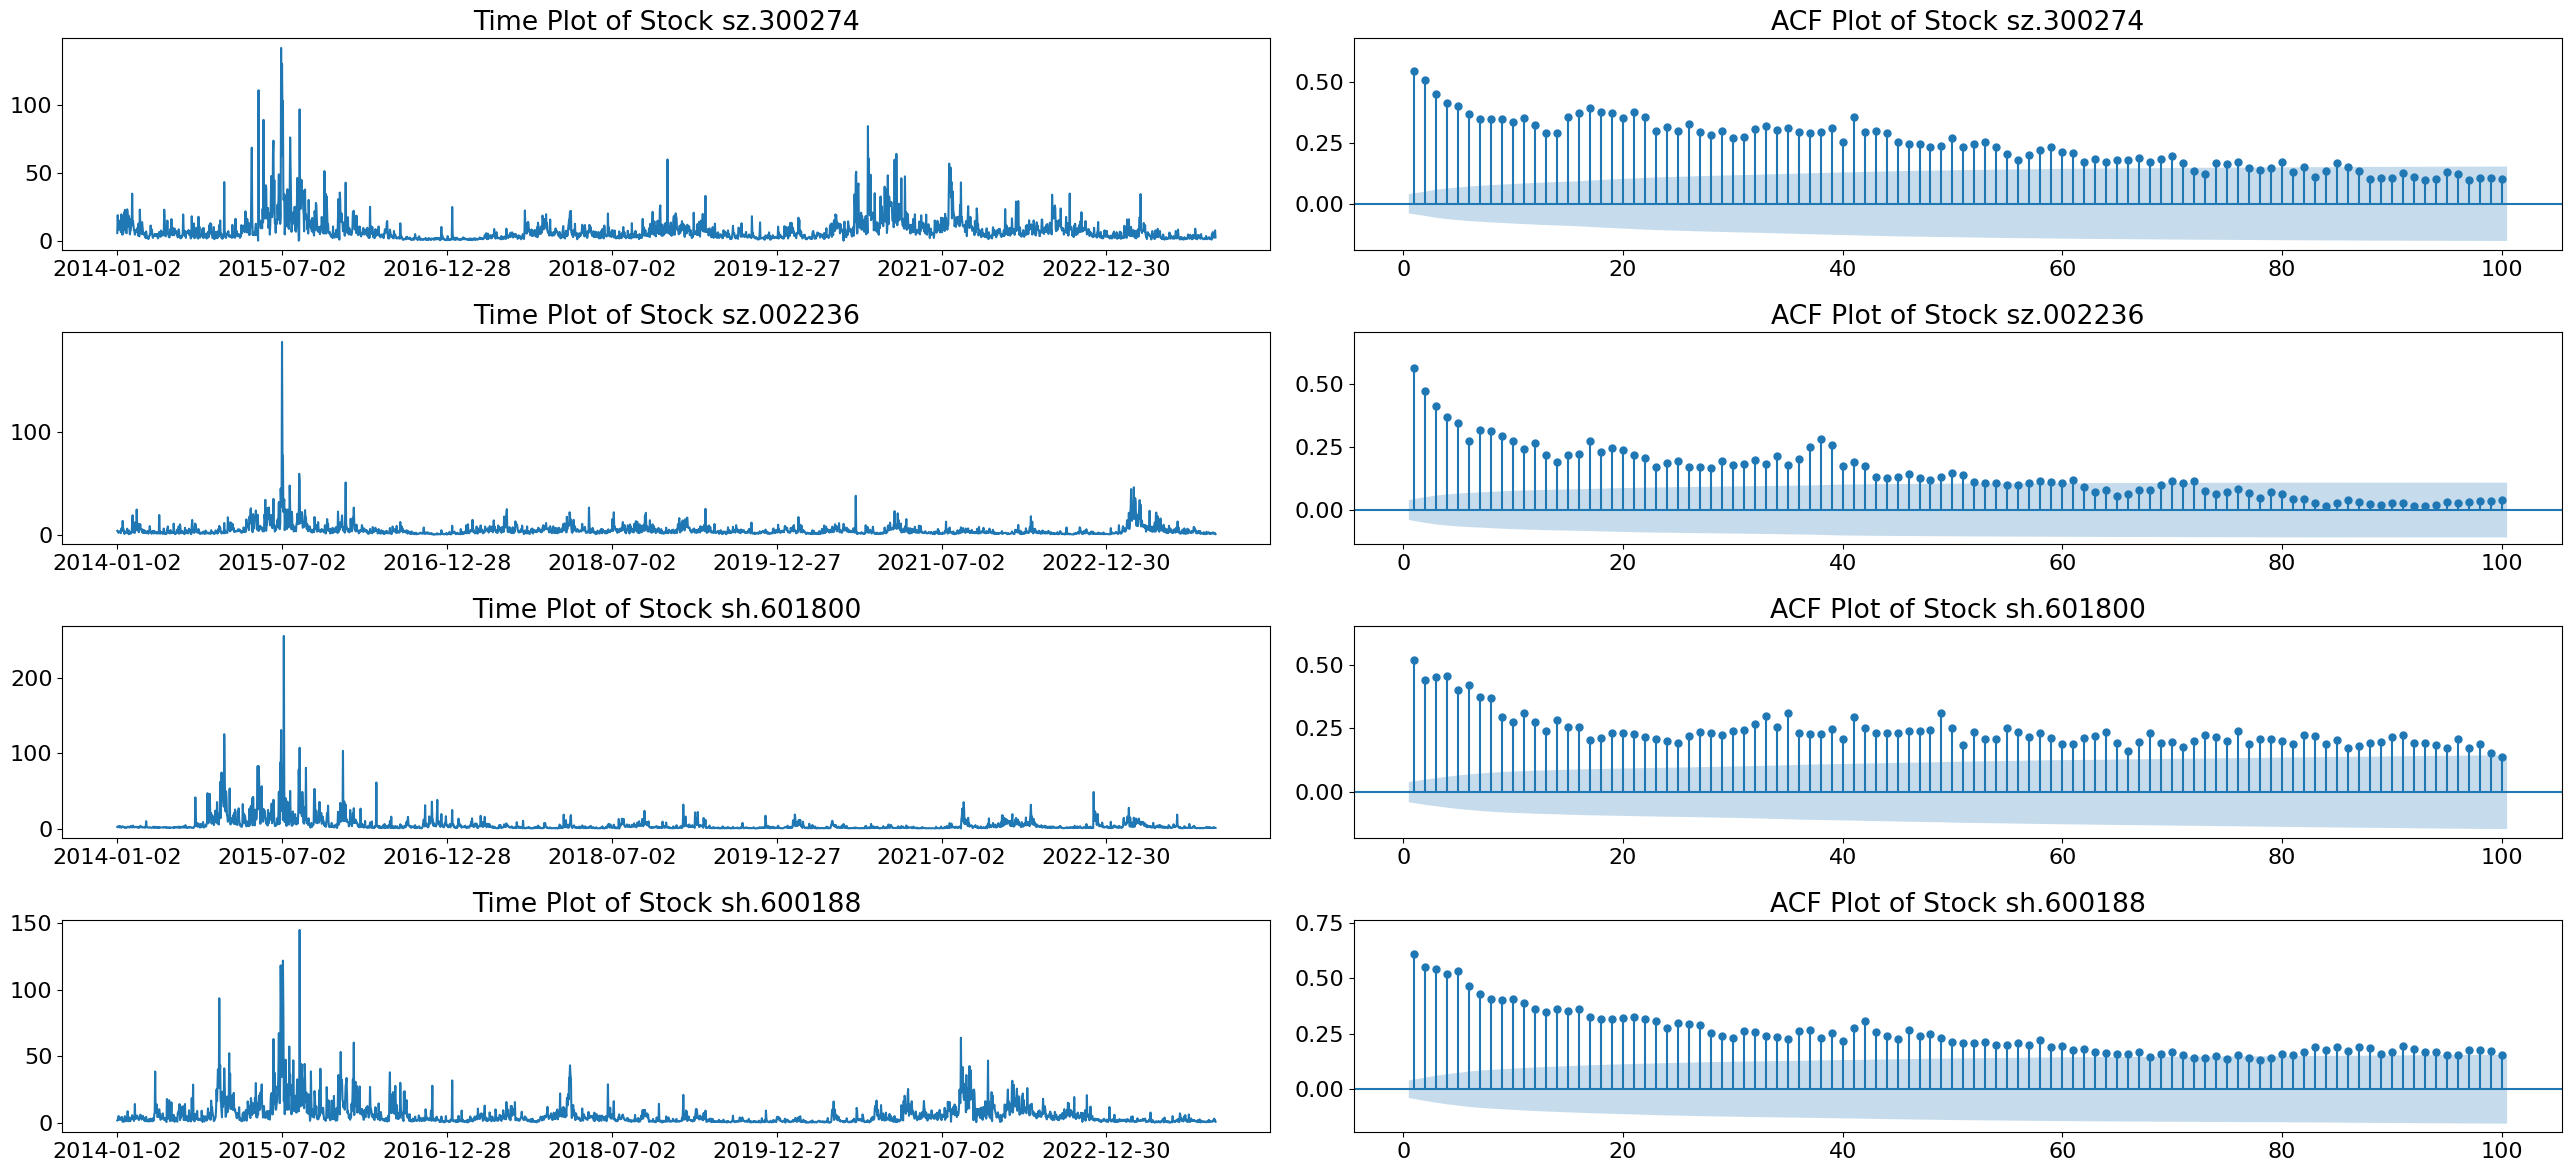

In [67]:
def time_plot(rv_table, seed=546):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from statsmodels.graphics.tsaplots import plot_acf
    import matplotlib as mpl

    mpl.rcParams['font.size'] = 16
    np.random.seed(seed)
    selected_columns = rv_table.sample(n=8, axis=1).columns

    fig, axes = plt.subplots(4, 2, figsize=(26, 12))
    axes = axes.ravel()  # flatten axes

    for i, column in enumerate(selected_columns):
        axes[2 * i].plot(rv_table.index, rv_table[column])
        axes[2 * i].set_title(f'Time Plot of Stock {column}')
        axes[2 * i].xaxis.set_major_locator(mdates.YearLocator())  # set x-axis major ticks to the first of every year
        plot_acf(rv_table[column], auto_ylims=True, zero=False, lags=100, ax=axes[2 * i + 1], title=f'ACF Plot of Stock {column}')

    plt.tight_layout()
    plt.savefig('../../images/rv_time_plot.pdf')

## Auto Covariance Matrix

This section provides functions to calculate the auto covariance matrix of the realized volatility data. The auto covariance matrix helps in understanding the temporal relationships between different stocks in the HS300 index.

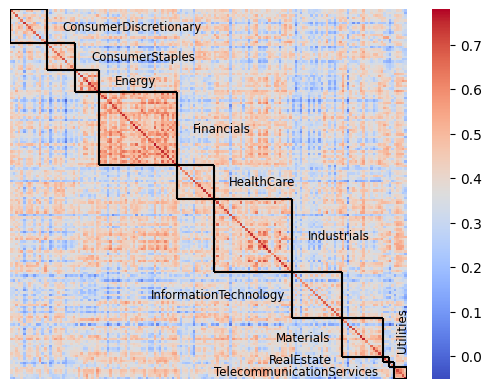

In [2]:
def cal_correlation(x, y):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    std_x = np.std(x)
    std_y = np.std(y)
    
    corr = np.mean((x - mean_x) * (y - mean_y)) / (std_x * std_y)
    return corr
    
def auto_covariance_matrix_manual(lag):
    data = pd.read_csv('realized_volatility/log_rv_table.csv', index_col=0)
    data_lag = data.shift(lag)
    columns = data.columns

    data = np.array(data[lag:])
    data_lag = np.array(data_lag[lag:])
    num_vars = data.shape[1]

    corr_matrix = [[cal_correlation(data[:, i], data_lag[:, j]) if cal_correlation(data[:, i], data_lag[:, j]) > 0.4 else 0 for j in range(num_vars)] for i in range(num_vars)]
    corr_matrix = [[cal_correlation(data[:, i], data_lag[:, j]) for j in range(num_vars)] for i in range(num_vars)]

    corr_matrix = np.array(corr_matrix)
    
    hs300_stocks = pd.read_csv('hs300_stocks.csv', index_col=0)
    sectors = hs300_stocks[hs300_stocks['code'].isin(columns)]['sector_code'].values
    unique_sectors = np.unique(sectors)
    sector_dict = {sector: i for i, sector in enumerate(unique_sectors)}
    sector_index = [sector_dict[sector] for sector in sectors]
    sector_dict_num = {sector: np.sum(sectors == sector) for sector in unique_sectors}
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    ax = sns.heatmap(corr_matrix, xticklabels=False, yticklabels=False, cmap='coolwarm')
    ax.set(xlabel=None, ylabel=None)
    index = 0
    for key, value in sector_dict_num.items():
        offset_y = 0
        if key == 'InformationTechnology':
            offset_x = -73
        elif key == 'Materials':
            offset_x = -41
        elif key == 'RealEstate':
            offset_x = -46
            offset_y = 0
        elif key == 'TelecommunicationServices':
            offset_x = -69
            offset_y = 3
        elif key == 'Utilities':
            offset_x = -value + 1
            offset_y = -value / 2 - 15
        else:
            offset_x = 6
        if key == 'Utilities':
            rotation = 90
        else:
            rotation = 0
        plt.text(index + value + offset_x, index + value / 2 + offset_y, key, va='center', fontsize=8.5, rotation = rotation)
        plt.hlines(index, index, index + value, colors='black')
        plt.hlines(index + value, index, index + value, colors='black')
        plt.vlines(index, index, index + value, colors='black')
        plt.vlines(index + value, index, index + value, colors='black')
        index += value
    
    plt.savefig('../../images/heatmap.pdf')

    return corr_matrix

ccm_manual = auto_covariance_matrix_manual(1)

## Group Stocks by Sector

In this section, we organize the stocks in the HS300 index by their respective sectors (Table B.4 in the Appendix B).

In [ ]:
rv_table = pd.read_csv('realized_volatility/log_rv_table.csv', index_col=0)
columns = rv_table.columns.values
abbreviations = hs300_stocks.loc[hs300_stocks['code'].isin(columns)]['abbrev_symbol'].values
sectors = hs300_stocks.loc[hs300_stocks['code'].isin(columns)]['sector_code']
sector_list = sectors.values

df_list = []
sec = sector_list[0]
sub_list = []
for i in range(152):
    if sector_list[i] == sec:
        sub_list.append(abbreviations[i])
    else:
        print(sub_list)
        sec = sector_list[i]
        df_list.append(sub_list)
        sub_list = [abbreviations[i]]

df_list.append(sub_list)
# Pivot the DataFrame
df = pd.DataFrame(data=df_list).T
df.columns = np.unique(sectors)
df.to_csv('stock_sector.csv')